In [13]:
# dataframe opertations - pandas
import pandas as pd
import numpy as np
import time 
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import kruskal

In [2]:
#health = pd.read_csv('../output/cut-data.csv',
#    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health = pd.read_csv('../output/08311.csv',
    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health


,occupancy
dates,
2020-04-24,127
2020-04-25,126
2020-04-26,125
2020-04-27,128
2020-04-28,133
...,...
2024-04-15,182
2024-04-16,186
2024-04-17,186


In [3]:

print(health.shape)
print(health.head())

(1457, 1)
            occupancy
dates                
2020-04-24        127
2020-04-25        126
2020-04-26        125
2020-04-27        128
2020-04-28        133


<Axes: title={'center': 'occupancy Data'}, xlabel='dates'>

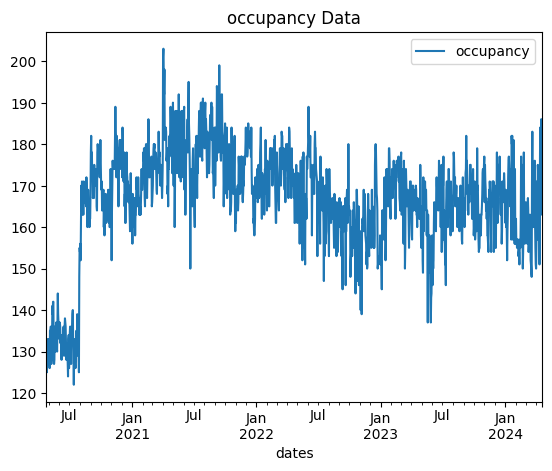

In [4]:

health[['occupancy']].plot(title='occupancy Data')

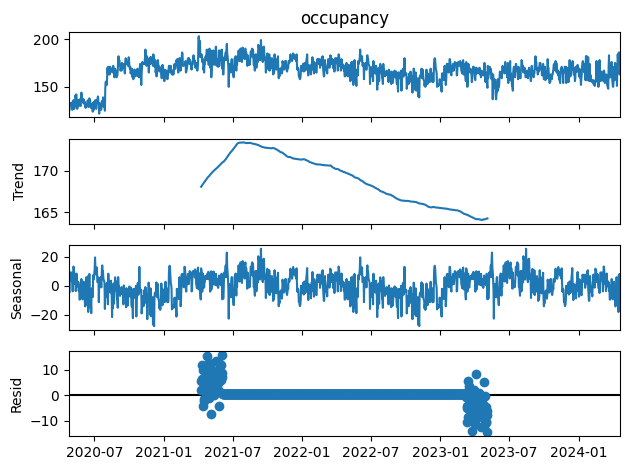

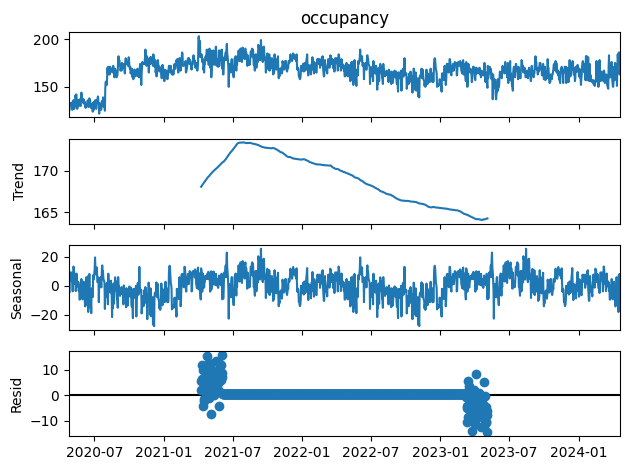

In [12]:
health.index.freq = 'D'
decompose_result = seasonal_decompose(health['occupancy'],model='additive',period=700)
decompose_result.plot()

In [6]:
# Set the frequency of the date time index as Monthly start as indicated by the data
health.index.freq = 'D'
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='dates'>

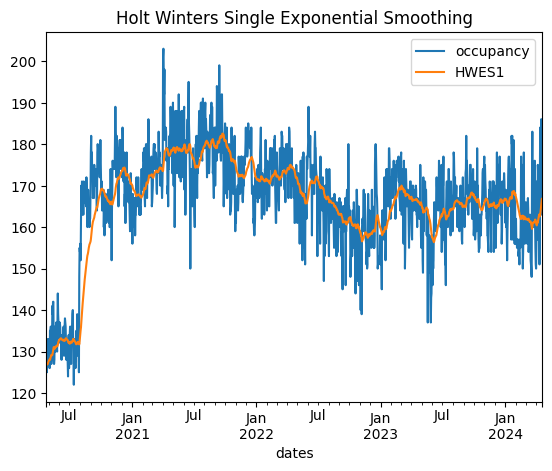

In [7]:
health['HWES1'] = SimpleExpSmoothing(health['occupancy']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
health[['occupancy','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='dates'>

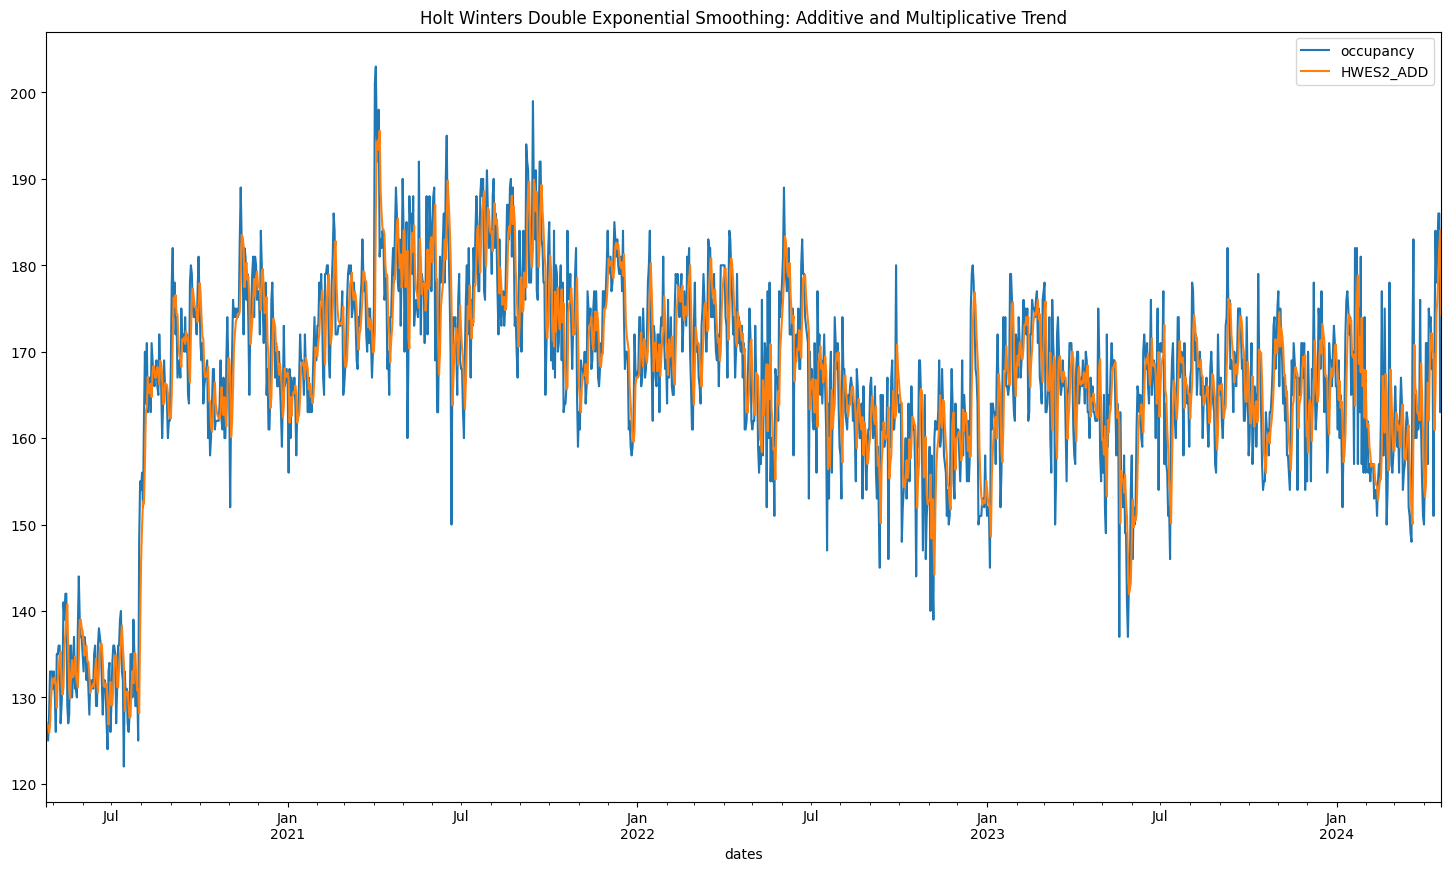

In [8]:
health['HWES2_ADD'] = ExponentialSmoothing(health['occupancy'],trend='add').fit().fittedvalues
health['HWES2_MUL'] = ExponentialSmoothing(health['occupancy'],trend='mul').fit()
health[['occupancy','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend',figsize=(18,10))

c:\Users\nguye\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\nguye\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='dates'>

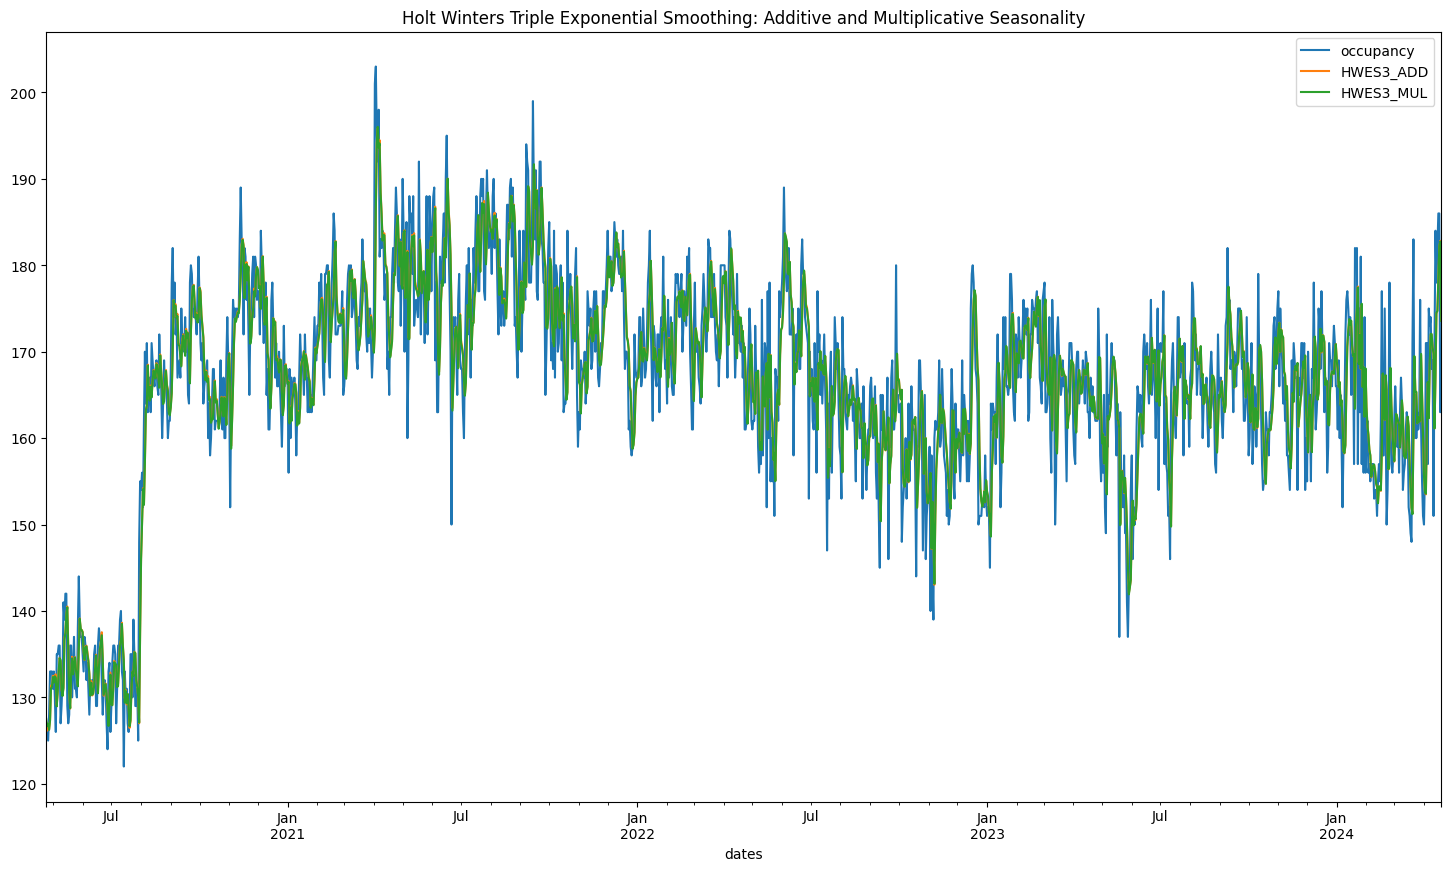

In [9]:
health['HWES3_ADD'] = ExponentialSmoothing(health['occupancy'],trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues
health['HWES3_MUL'] = ExponentialSmoothing(health['occupancy'],trend='mul',seasonal='mul',seasonal_periods=24).fit().fittedvalues
health[['occupancy','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality',figsize=(18,10))

In [26]:
#health = pd.read_csv('../output/cut-data.csv',
#    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health = pd.read_csv('../output/08311.csv',
    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health.index.freq = 'D'
target_days = 30
holt_params = {
    'trend': 'add', 
    'damped_trend': False,
    'seasonal': 'mul', 
    'seasonal_periods': 350,
    'initialization_method': 
    'heuristic'}
#train and test
train_health = health[0:len(health)-target_days]
test_health = health[len(health)-target_days:len(health)]

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

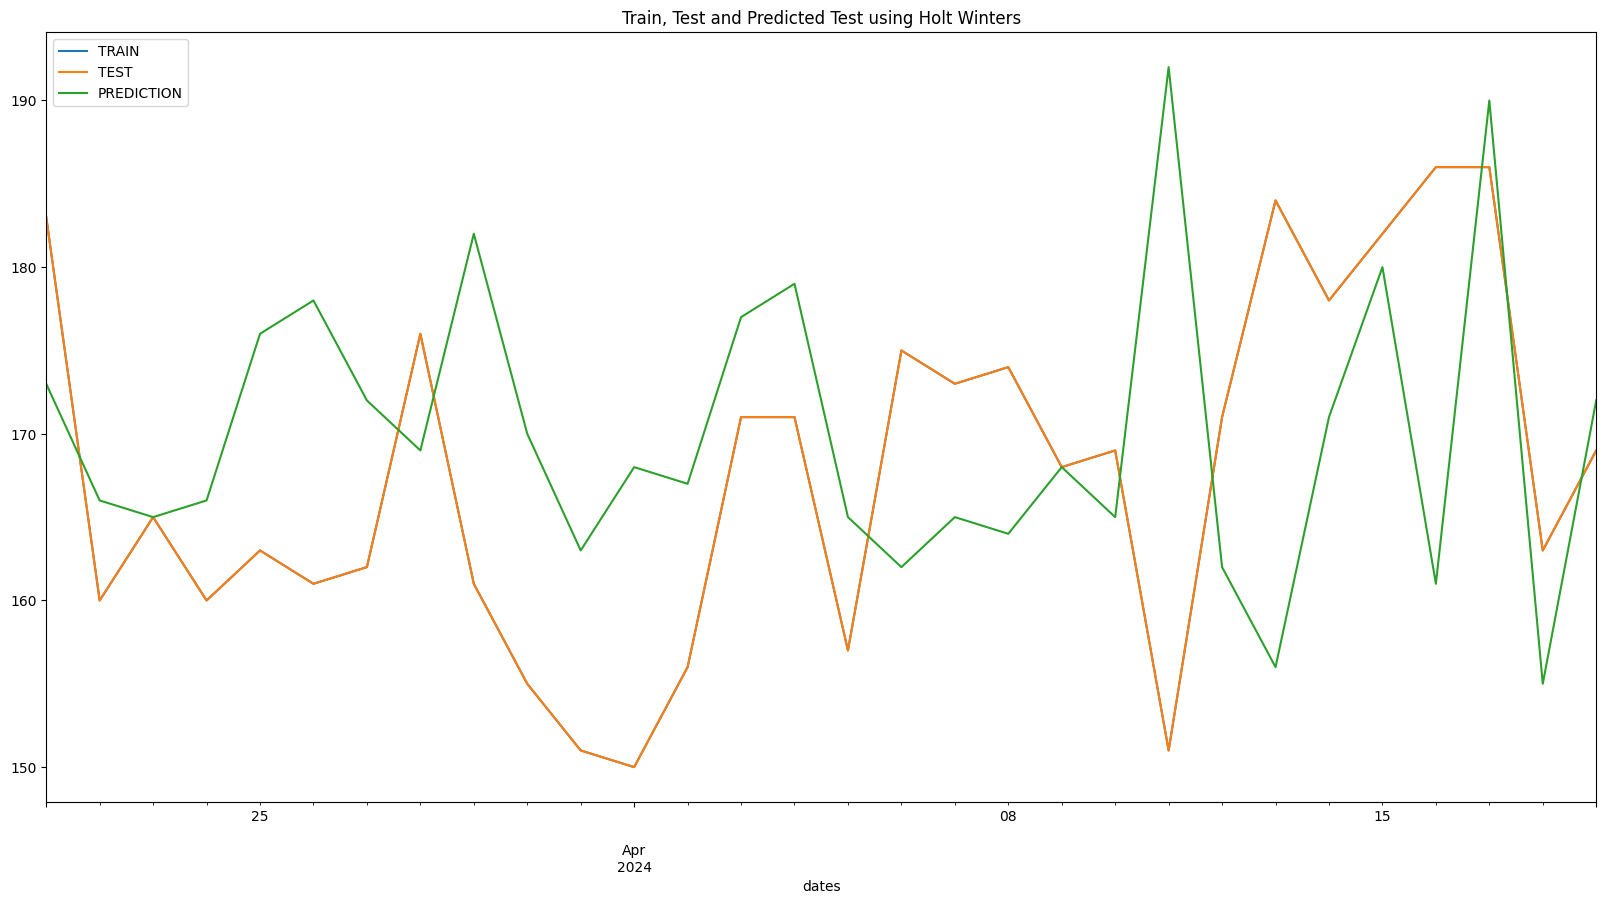

In [28]:
fitted_model = ExponentialSmoothing(train_health['occupancy'],**holt_params).fit(smoothing_level=0.8,smoothing_trend=0.2,
                                                                            smoothing_seasonal=0.9)
test_predictions = fitted_model.forecast(target_days)
test_predictions = test_predictions.astype(int)
test_health['occupancy'].plot(legend=True,label='TRAIN')
test_health['occupancy'].plot(legend=True,label='TEST',figsize=(20,10))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')


<Axes: xlabel='dates'>

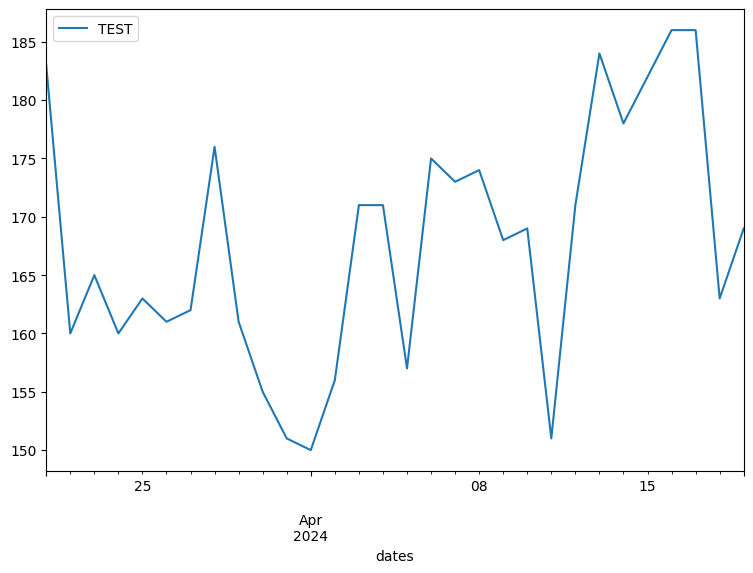

In [ ]:
test_health['occupancy'].plot(legend=True,label='TEST',figsize=(9,6))
#test_predictions.plot(legend=True,label='PREDICTION',xlim=['1959–01–01','1961–01–01'])

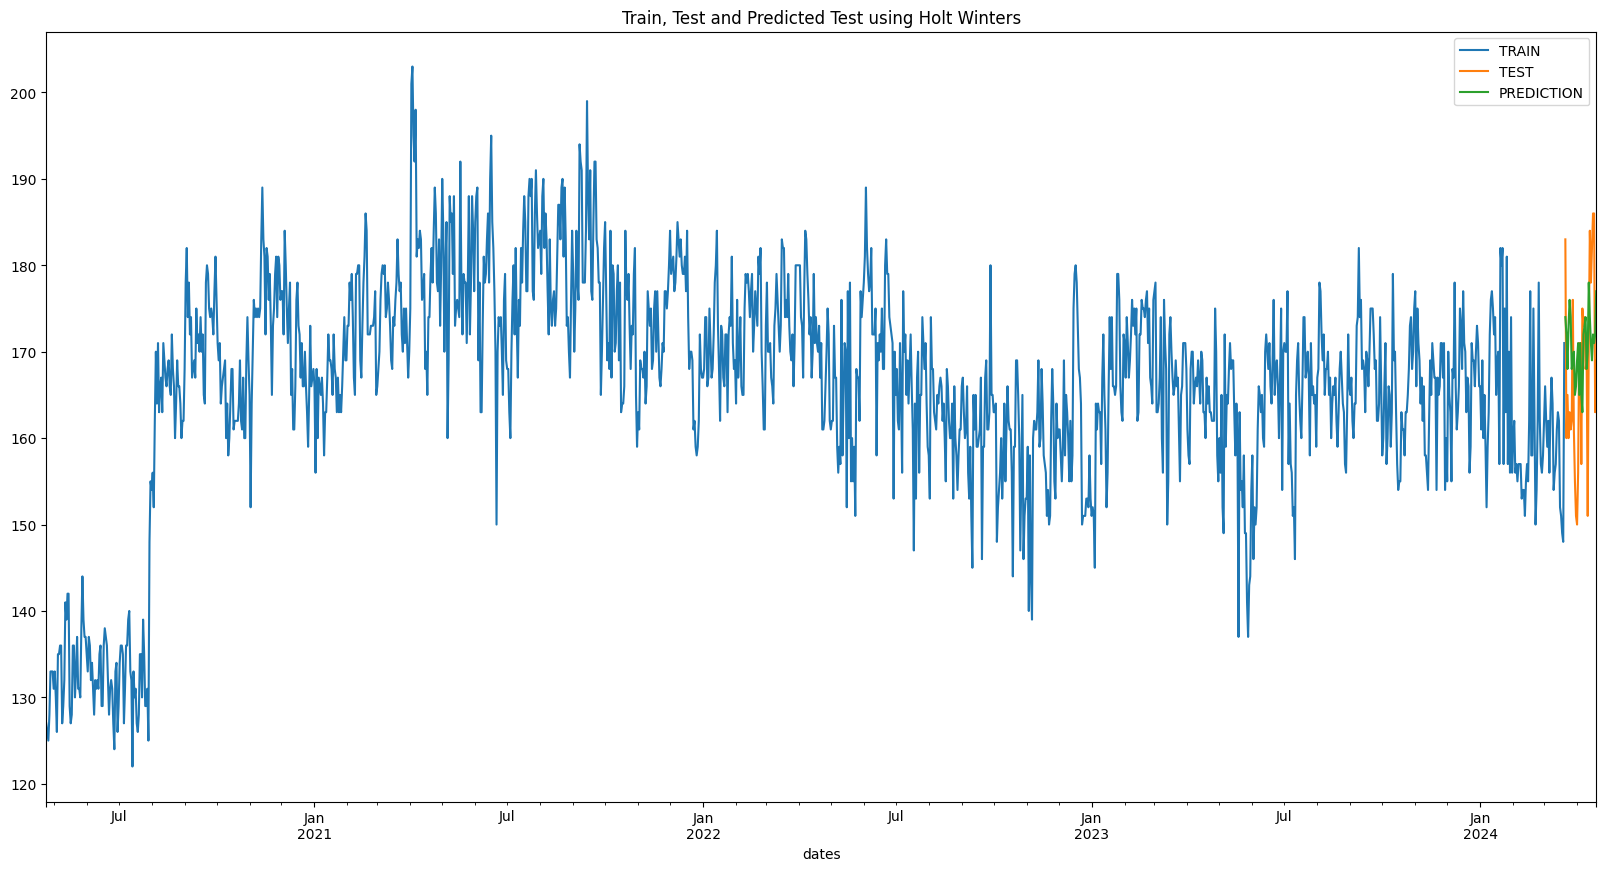

In [ ]:
plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot the training data
train_health['occupancy'].plot(legend=True, label='TRAIN')

# Plot the test data
test_health['occupancy'].plot(legend=True, label='TEST')

# Plot the predicted values
test_predictions.plot(legend=True, label='PREDICTION')

plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()  # Show the plot

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
print(f'Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_health,test_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}')
print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}')

Mean Absolute Error = 9.366666666666667
Mean Squared Error = 113.16666666666667
Root Mean Squared Error = 10.637982264821966
Mean Absolute Percentage Error = 0.05672006843196397


In [ ]:
unix_timestamp = int(time.time())
#output_file = (
#    '../output/holt_winter/holt-winter-%d.csv' % unix_timestamp
#)
output_file = (
    '../output/holt_winter/holt-winter-08311-%d.csv' % unix_timestamp
)

In [ ]:
#fill the csv with the prediction data
out = (f'target_days: {target_days}\n' )
out = out + "parameters: \n"
for i in holt_params: 
    out = out + (f'{i}: {holt_params[i]}\n')
out = out + (f'Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}\n')
out = out + (f'Mean Squared Error = {mean_squared_error(test_health,test_predictions)}\n')
out = out + (f'Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}\n')
out = out + (f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}\n')

out = out + 'dates' + ',' + 'occupancy' + '\n'

for i in range(len(test_predictions)):
    out = out + str((train_health.index[len(train_health)-1] + pd.DateOffset(i)).date()) + ',' + str(test_predictions.iloc[i]) + '\n'

with open(output_file,'w') as f:
    f.write(out)


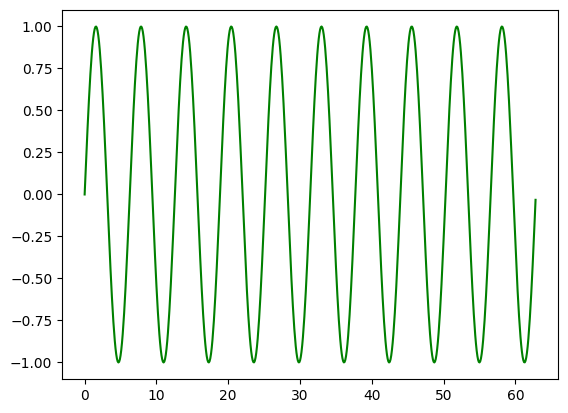

In [ ]:
x = np.arange(0,20*np.pi,0.1)
sinus = np.sin(x)
plt.plot(x, sinus, color='green')
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Generate date range
start_date = '2024-01-01'
end_date = '2025-01-01'
dates = pd.date_range(start=start_date, end=end_date)

# Generate sinus data
amplitude = 1  # Amplitude of the sinus wave
frequency = 0.1  # Frequency of the sinus wave
phase = 0  # Phase shift of the sinus wave
sinus_data = amplitude * np.sin(np.pi * frequency * np.arange(len(dates)) + phase)



# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Sinus_Value': sinus_data})
df.set_index('Date', inplace=True)


print(df.head())


            Sinus_Value
Date                   
2024-01-01     0.000000
2024-01-02     0.309017
2024-01-03     0.587785
2024-01-04     0.809017
2024-01-05     0.951057


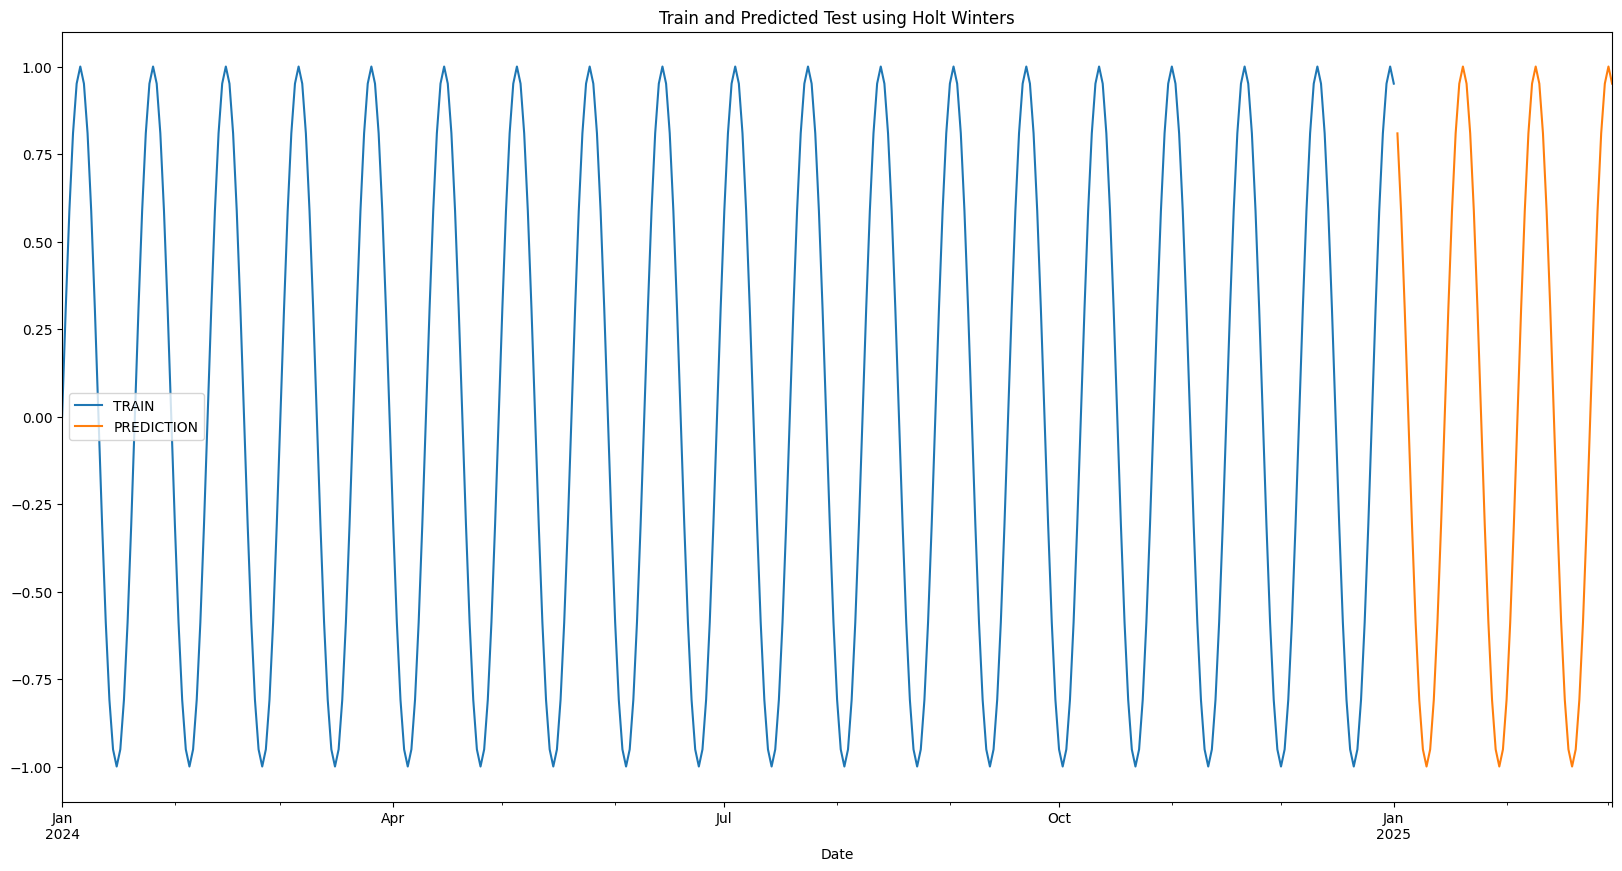

In [ ]:
df.index.freq = 'D'

sinus_model = ExponentialSmoothing(df['Sinus_Value'],trend=None,seasonal='add',seasonal_periods=60).fit()

predictions_sinus = sinus_model.forecast(60)

plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot the training data
df['Sinus_Value'].plot(legend=True, label='TRAIN')

# Plot the test data
predictions_sinus.plot(legend=True, label='PREDICTION')



plt.title('Train and Predicted Test using Holt Winters')
plt.show()  # Show the plot
